In [1]:
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

###Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import copy
import os

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 512 if torch.cuda.is_available() else 256

In [4]:
loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()
])

In [5]:
def image_loader(image_path, size=imsize):
    image = Image.open(image_path).convert("RGB")
    image = transforms.Resize((size, size))(image)
    image = transforms.ToTensor()(image).unsqueeze(0)
    return image.to(device, torch.float)


In [6]:
content_img = image_loader("model1.jpg")
style_img = image_loader("lempicka_portrait1.jpg")

In [7]:
assert content_img.size() == style_img.size(), "Images must be the same size!"

In [8]:
def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title: plt.title(title)
    plt.axis('off')
    plt.show()

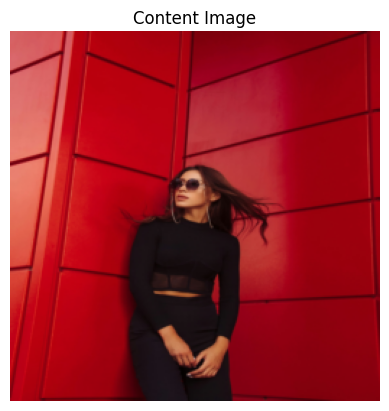

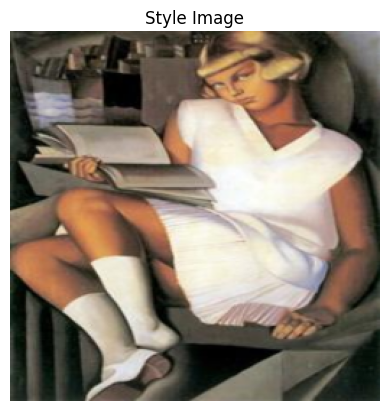

In [9]:
imshow(content_img, title="Content Image")
imshow(style_img, title="Style Image")

In [10]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = nn.functional.mse_loss(input, self.target)
        return input

def gram_matrix(input):
    b, c, h, w = input.size()
    features = input.view(b * c, h * w)
    G = torch.mm(features, features.t())
    return G.div(b * c * h * w)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = nn.functional.mse_loss(G, self.target)
        return input


In [11]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

# Normalization params (used in VGG training)
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:31<00:00, 18.3MB/s]


In [12]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.view(-1, 1, 1)
        self.std = std.view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std


In [13]:
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f"conv_{i}"
        elif isinstance(layer, nn.ReLU):
            name = f"relu_{i}"
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f"pool_{i}"
        elif isinstance(layer, nn.BatchNorm2d):
            name = f"bn_{i}"
        else:
            continue

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target = model(style_img).detach()
            style_loss = StyleLoss(target)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    # Trim after last loss layer
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], (ContentLoss, StyleLoss)):
            break
    model = model[:i+1]

    return model, style_losses, content_losses


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


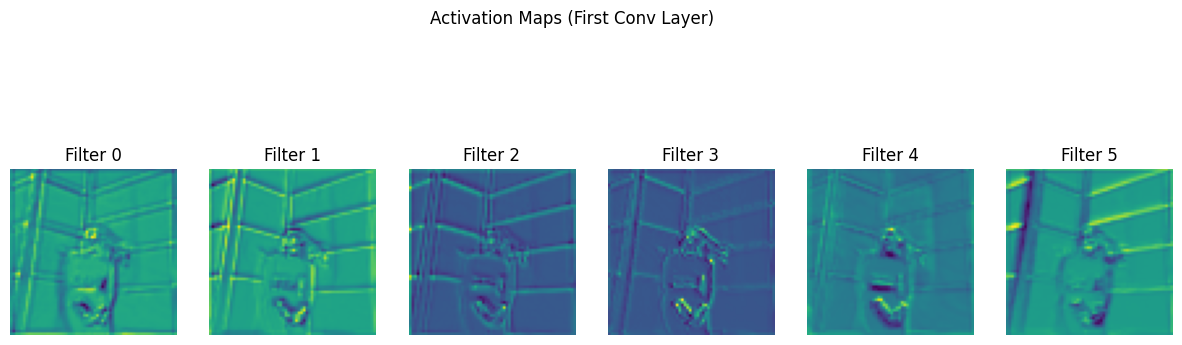

In [14]:
# Extract feature maps from the first few layers of VGG
from torchvision.models import vgg19

vgg = models.vgg19(pretrained=True).features.to(device).eval()

def get_activation(model, layer_num, image):
    activation = image.clone()
    for i, layer in enumerate(model):
        activation = layer(activation)
        if i == layer_num:
            return activation

activation_maps = get_activation(vgg, 10, content_img)


def plot_activations(activation, num_channels=6):
    act = activation.cpu().squeeze(0)  #remove batch dim
    fig, axes = plt.subplots(1, num_channels, figsize=(15, 5))
    for i in range(num_channels):
        axes[i].imshow(act[i].detach(), cmap='viridis')
        axes[i].axis('off')
        axes[i].set_title(f'Filter {i}')
    plt.suptitle("Activation Maps (First Conv Layer)")
    plt.show()

plot_activations(activation_maps, num_channels=6)


### My first styled image

In [15]:
input_img = content_img.clone()
input_img.requires_grad_(True)


tensor([[[[0.8353, 0.8314, 0.8314,  ..., 0.5765, 0.5765, 0.5765],
          [0.8353, 0.8353, 0.8353,  ..., 0.5765, 0.5765, 0.5804],
          [0.8392, 0.8353, 0.8392,  ..., 0.5843, 0.5843, 0.5882],
          ...,
          [0.5216, 0.6745, 0.6941,  ..., 0.5137, 0.5137, 0.5137],
          [0.6078, 0.6902, 0.6941,  ..., 0.5137, 0.5098, 0.5137],
          [0.6235, 0.6863, 0.6941,  ..., 0.5137, 0.5059, 0.5098]],

         [[0.3686, 0.3804, 0.3804,  ..., 0.0000, 0.0000, 0.0000],
          [0.3725, 0.3804, 0.3804,  ..., 0.0000, 0.0000, 0.0000],
          [0.3725, 0.3843, 0.3843,  ..., 0.0000, 0.0000, 0.0039],
          ...,
          [0.0078, 0.0078, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
          [0.0078, 0.0039, 0.0000,  ..., 0.0039, 0.0000, 0.0039],
          [0.0078, 0.0039, 0.0000,  ..., 0.0039, 0.0000, 0.0039]],

         [[0.3804, 0.3804, 0.3804,  ..., 0.0627, 0.0627, 0.0627],
          [0.3804, 0.3843, 0.3843,  ..., 0.0627, 0.0627, 0.0627],
          [0.3804, 0.3882, 0.3922,  ..., 0

In [16]:
optimizer = optim.LBFGS([input_img])

In [17]:
model, style_losses, content_losses = get_style_model_and_losses(
    cnn, cnn_normalization_mean, cnn_normalization_std,
    style_img, content_img)

In [18]:
num_steps = 300
style_weight = 1e6
content_weight = 1

print("Optimizing...")

run = [0]
while run[0] <= num_steps:

    def closure():
        input_img.data.clamp_(0, 1)  # keep image values in [0, 1]

        optimizer.zero_grad()
        model(input_img)

        style_score = 0
        content_score = 0

        for sl in style_losses:
            style_score += sl.loss
        for cl in content_losses:
            content_score += cl.loss

        style_score *= style_weight
        content_score *= content_weight

        loss = style_score + content_score
        loss.backward()

        if run[0] % 50 == 0:
            print(f"Step {run[0]}:")
            print(f"Style Loss: {style_score.item():.4f} | Content Loss: {content_score.item():.4f}")

        run[0] += 1
        return loss

    optimizer.step(closure)

# Clamp one last time
input_img.data.clamp_(0, 1)


Optimizing...
Step 0:
Style Loss: 20270.3008 | Content Loss: 0.0000
Step 50:
Style Loss: 73.7136 | Content Loss: 17.3331
Step 100:
Style Loss: 33.4459 | Content Loss: 16.5665
Step 150:
Style Loss: 24.5574 | Content Loss: 15.5311
Step 200:
Style Loss: 18.3218 | Content Loss: 15.0610
Step 250:
Style Loss: 13.6496 | Content Loss: 14.8657
Step 300:
Style Loss: 9.9695 | Content Loss: 14.5865


tensor([[[[0.9441, 0.7904, 0.8694,  ..., 0.6910, 0.6341, 0.7373],
          [0.9001, 0.7586, 0.8346,  ..., 0.6125, 0.5347, 0.6777],
          [0.9836, 0.8745, 0.9346,  ..., 0.6358, 0.6000, 0.7563],
          ...,
          [0.0000, 0.0000, 0.1167,  ..., 0.3903, 0.4256, 0.5723],
          [0.0000, 0.0000, 0.0000,  ..., 0.3306, 0.3072, 0.4636],
          [0.0000, 0.0000, 0.1071,  ..., 0.5731, 0.5483, 0.6954]],

         [[0.5658, 0.5803, 0.5965,  ..., 0.5144, 0.5393, 0.5570],
          [0.5439, 0.5787, 0.6101,  ..., 0.4238, 0.4831, 0.5333],
          [0.5184, 0.5682, 0.6195,  ..., 0.4160, 0.5310, 0.5387],
          ...,
          [0.1517, 0.0257, 0.0547,  ..., 0.1746, 0.2446, 0.3111],
          [0.1497, 0.0126, 0.1580,  ..., 0.2047, 0.2963, 0.3389],
          [0.0202, 0.2177, 0.1736,  ..., 0.2943, 0.3614, 0.4543]],

         [[0.4736, 0.5064, 0.3559,  ..., 0.3716, 0.4794, 0.5031],
          [0.5673, 0.7007, 0.5028,  ..., 0.4217, 0.5096, 0.5362],
          [0.5456, 0.6734, 0.4526,  ..., 0

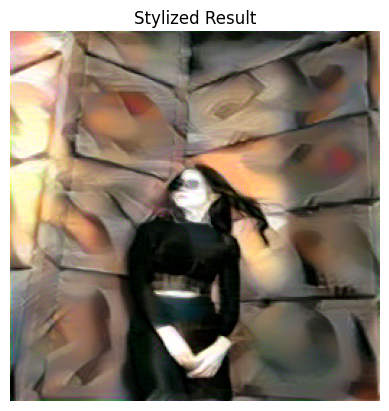

In [19]:
imshow(input_img, title="Stylized Result")


Not bad, let's try in a new image

### The second try

In [21]:
content_img = image_loader("model2.jpeg", size=512)
style_img = image_loader("lempicka_portrait2.jpg", size=512)

In [22]:
model, style_losses, content_losses = get_style_model_and_losses(
    cnn, cnn_normalization_mean, cnn_normalization_std,
    style_img, content_img)


In [23]:
input_img = content_img.clone()
input_img.requires_grad_(True)
optimizer = optim.LBFGS([input_img])


In [24]:
num_steps = 300
style_weight = 1e6
content_weight = 1

print("Optimizing...")

run = [0]
while run[0] <= num_steps:

    def closure():
        input_img.data.clamp_(0, 1)  # keep image values in [0, 1]

        optimizer.zero_grad()
        model(input_img)

        style_score = 0
        content_score = 0

        for sl in style_losses:
            style_score += sl.loss
        for cl in content_losses:
            content_score += cl.loss

        style_score *= style_weight
        content_score *= content_weight

        loss = style_score + content_score
        loss.backward()

        if run[0] % 50 == 0:
            print(f"Step {run[0]}:")
            print(f"Style Loss: {style_score.item():.4f} | Content Loss: {content_score.item():.4f}")

        run[0] += 1
        return loss

    optimizer.step(closure)

# Clamp one last time
input_img.data.clamp_(0, 1)


Optimizing...
Step 0:
Style Loss: 2547.0156 | Content Loss: 0.0000
Step 50:
Style Loss: 66.0156 | Content Loss: 11.1208
Step 100:
Style Loss: 10.9971 | Content Loss: 10.8593
Step 150:
Style Loss: 6.2205 | Content Loss: 9.6479
Step 200:
Style Loss: 4.3623 | Content Loss: 8.8471
Step 250:
Style Loss: 3.2299 | Content Loss: 8.3558
Step 300:
Style Loss: 2.3721 | Content Loss: 8.0598


tensor([[[[0.4833, 0.3766, 0.4109,  ..., 0.2275, 0.2149, 0.2536],
          [0.4281, 0.3644, 0.5026,  ..., 0.2343, 0.1956, 0.1248],
          [0.4062, 0.4012, 0.4352,  ..., 0.1891, 0.1510, 0.1042],
          ...,
          [0.3860, 0.1787, 0.1841,  ..., 0.6781, 0.5884, 0.6270],
          [0.3212, 0.1185, 0.2037,  ..., 0.5320, 0.4349, 0.5046],
          [0.3401, 0.1348, 0.2029,  ..., 0.5847, 0.5342, 0.5962]],

         [[0.6733, 0.5885, 0.5049,  ..., 0.2922, 0.2971, 0.3177],
          [0.5786, 0.4133, 0.4192,  ..., 0.1726, 0.2140, 0.1900],
          [0.5118, 0.3982, 0.4035,  ..., 0.1399, 0.1469, 0.1347],
          ...,
          [0.2455, 0.1769, 0.1826,  ..., 0.3780, 0.4413, 0.4072],
          [0.1920, 0.1550, 0.1094,  ..., 0.4612, 0.5214, 0.4686],
          [0.2321, 0.1359, 0.1489,  ..., 0.4798, 0.4815, 0.4407]],

         [[0.4905, 0.5687, 0.5397,  ..., 0.3308, 0.3447, 0.3428],
          [0.5207, 0.5239, 0.5054,  ..., 0.1275, 0.1457, 0.2550],
          [0.5453, 0.5905, 0.4779,  ..., 0

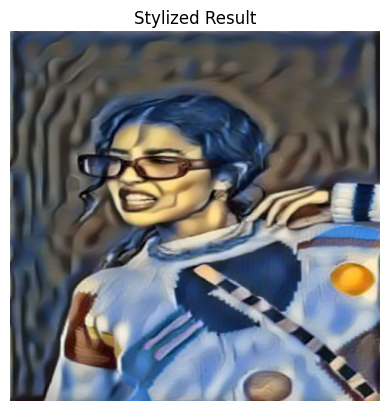

In [25]:
imshow(input_img, title="Stylized Result")